First, we need to import all of the dependencies for the model.

In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import logging
logger = logging.getLogger(__name__)
logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S', level=logging.DEBUG)

import os
import numpy as np
import time
from io import open
import math
import cPickle as pkl
import yaml

os.environ["THEANO_FLAGS"] = "floatX=float32,device=gpu0"
import theano

from model import Model
from utils import get_vocabulary, dump_params, load_params, iterate_pkl_minibatches, iterate_minibatches
import tables
from sklearn.metrics.pairwise import cosine_similarity


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)


Now we will define a Tester class that we can call from our notebook

In [2]:
class Tester:
    def __init__(self, config, shared_theano_params=None):
        self.config = config
        if config['exp_id'] != '':
            # helps us keep the parameters in different spaces
            # instead of only in the same model_name file
            config['model_name'] = '{}-{}'.format(config['exp_id'], config['model_name'])
        self.train_path = config['train']
        self.fc7_path = config['fc7_train']
        self.val_path = config['val']
        self.val_fc7_path = config['fc7_val']
        self.model = Model(config, load=True)
        self.update_count = 0
        self.batch_size = config['batch_size']
        self.use_dropout = config['dropout']
        self.verbose = config['verbose']

    def get_val_data_iterator(self):
        """
        Returns an iterator over validation data.

        Returns: iterator
        """
        if self.val_path.endswith('pkl'):
            return iterate_pkl_minibatches(self.val_path, self.val_fc7_path, shuffle=False,
                                       batch_size=self.batch_size)
        else:
            return iterate_minibatches(self.val_path, self.val_fc7_path, shuffle=False,
                                       batch_size=self.batch_size)

    def get_predictions(self):
        # Collect the predicted image vectors on the validation dataset
        # We do this is batches so a dataset with a large validation split
        # won't cause GPU OutOfMemory errors.
        all_preds = None
        for sentences in self.get_val_data_iterator():
            x, x_mask, y = self.model.prepare_batch(sentences[0], sentences[1])
            predictions = self.model.predict_on_batch(x, x_mask)
            if all_preds == None:
                all_preds = predictions
            else:
                all_preds = np.vstack((all_preds, predictions))
        return all_preds

    def calculate_ranking(self, predictions, fc7_path, k=1, npts=None):
        """
        :param predictions: matrix of predicted image vectors
        :param fc7_path: path to the true image vectors
        :param k: number of predictions per image (usually based on the number
        of sentence encodings)

        TODO: vectorise the calculation
        """

        # Normalise the predicted vectors
        for i in range(len(predictions)):
            predictions[i] /= np.linalg.norm(predictions[i])

        fc7_file = tables.open_file(fc7_path, mode='r')
        fc7_vectors = fc7_file.root.feats[:]
        images = fc7_vectors[:]

        # Normalise the true vectors
        for i in range(len(images)):
            images[i] /= np.linalg.norm(images[i])

        if npts == None:
            npts = predictions.shape[0]
            if npts > 25000:
                # The COCO validation pkl contains 25,010 instances???
                npts = 25000

        ranks = np.full(len(images), 1e20)
        for index in range(npts):
            # Get the predicted image vector
            p = predictions[index]

            # Compute cosine similarity between predicted vector and the
            # true vectors
            sim = np.dot(p, images.T)
            inds = np.argsort(sim) # should we reverse list?

            # Score
            # Iterate through the possible trues
            target = int(math.floor(index/k))
            tmp = np.where(inds == target)
            #print("Index {} target {} tmp {}".format(index, target, tmp[0]))
            tmp = tmp[0][0]
            if tmp < ranks[target]:
                ranks[target] = tmp

        # Compute metrics
        r1, r5, r10, medr = self.ranking_results(ranks)
        return (r1, r5, r10, medr)

    def ranking_results(self, ranks):
        r1 = 100.0 * len(np.where(ranks < 1)[0]) / len(ranks)
        r5 = 100.0 * len(np.where(ranks < 5)[0]) / len(ranks)
        r10 = 100.0 * len(np.where(ranks < 10)[0]) / len(ranks)
        medr = np.floor(np.median(ranks)) + 1
        logger.info('R@1 {} R@5 {} R@10 {} Median {}'.format(r1, r5, r10, medr))
        return r1, r5, r10, medr

    def predict_images(self):
        """ 
        Predict the most likely images, given sentences 
        """

        logger.info('Imagineting the dev set')
        start_time = time.time()

        # Collect the predicted image vectors on the validation dataset
        # We do this is batches so a dataset with a large validation split
        # won't cause GPU OutOfMemory errors.
        all_preds = self.get_predictions()

        # Measure the ranking performance on the validation dataset
        self.calculate_ranking(all_preds, self.config['fc7_val'], k=self.config['ranking_k'])

    def test(self):
        self.predict_images()


Now we define a function to call the Tester class

In [3]:
def build_test(config):
    """
    Make predictions
    :param config: yaml-file with configuration
    :return:
    """

    # print config
    logger.info('Testing with the following (loaded) config:')
    for arg, value in config.items():
        logger.info('{}: {}'.format(arg, value))
    
    # load model
    tester = Tester(config)
    return tester

We need to load a configuration file that will help us build the model

In [4]:
#os.chdir('src/imaginet')
config_file = "configs/multi30k.inceptionv3.yaml"
config = yaml.load(open(config_file, mode='rb'))
config['exp_id'] = ''
config['word_vocabulary'] = '../nmt/data/wmt_task1/en_dict.json'
config['fc7_val'] = '../' + config['fc7_val']
config['val'] = '../' + config['val']
# Insane hack to get the correct path
config['model_name'] = '../../models/backup/run4-inceptionv3-w620-h1000-meanmlp-tanh-constrastive0.1-adam-1e-4-dropout_hid0.3-decay_c1e-8-alltoks.npz.29.medr11.0'
image_path = '/home/delliott/data/flickr30k/'
image_list_file = '../nmt/data/wmt_task1/val_images.txt'
with open(image_list_file) as f:
    image_list = [line.strip() for line in f]


In [47]:
def get_sentence(filename, index):
     with open(filename, mode='r', encoding='utf-8') as f:
        data = []
        i = 0
        for line in f:
            data.append((line.replace('\n',''), i))
            i += 1
        return data[index]
    
def calculate_top5(predictions, fc7_path, index, k=1, npts=None):
        """
        :param predictions: matrix of predicted image vectors
        :param fc7_path: path to the true image vectors
        :param k: number of predictions per image (usually based on the number
        of sentence encodings)

        TODO: vectorise the calculation
        """

        # Normalise the predicted vectors
        for i in range(len(predictions)):
            predictions[i] /= np.linalg.norm(predictions[i])

        fc7_file = tables.open_file(fc7_path, mode='r')
        fc7_vectors = fc7_file.root.feats[:]
        images = fc7_vectors[:]

        # Normalise the true vectors
        for i in range(len(images)):
            images[i] /= np.linalg.norm(images[i])

        if npts == None:
            npts = predictions.shape[0]
            if npts > 25000:
                # The COCO validation pkl contains 25,010 instances???
                npts = 25000

        # Get the predicted image vector
        p = predictions[index]

        # Compute cosine similarity between predicted vector and the
        # true vectors
        sim = np.dot(p, images.T)
        inds = np.argsort(sim) # should we reverse list?
        return inds

In [6]:
tester = build_test(config)

2017-01-30 14:46:18 - __main__ - INFO - Testing with the following (loaded) config:
2017-01-30 14:46:18 - __main__ - INFO - dropout_word: 0.0
2017-01-30 14:46:18 - __main__ - INFO - verbose: False
2017-01-30 14:46:18 - __main__ - INFO - learn_rnn_init: True
2017-01-30 14:46:18 - __main__ - INFO - fc7_val: ../nmt/data/wmt_task1/val-inceptionv3.hdf5
2017-01-30 14:46:18 - __main__ - INFO - final_birnn: False
2017-01-30 14:46:18 - __main__ - INFO - max_unk_ratio: 1.0
2017-01-30 14:46:18 - __main__ - INFO - dropout_hid: 0.0
2017-01-30 14:46:18 - __main__ - INFO - max_words: -1
2017-01-30 14:46:18 - __main__ - INFO - num_epochs: 100
2017-01-30 14:46:18 - __main__ - INFO - clip_c: 1.0
2017-01-30 14:46:18 - __main__ - INFO - ranking_k: 1
2017-01-30 14:46:18 - __main__ - INFO - mean_birnn: True
2017-01-30 14:46:18 - __main__ - INFO - val: ../nmt/data/wmt_task1/dev.en
2017-01-30 14:46:18 - __main__ - INFO - dropout_rec: 0.2
2017-01-30 14:46:18 - __main__ - INFO - init: ortho
2017-01-30 14:46:18 

In [7]:
tester.test()

2017-01-30 14:47:09 - __main__ - INFO - Imagineting the dev set
/home/delliott/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
2017-01-30 14:47:10 - __main__ - INFO - R@1 13.1163708087 R@5 34.8126232742 R@10 48.4220907298 Median 11.0


In [8]:
preds = tester.get_predictions()

/home/delliott/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import skimage
import skimage.transform
import skimage.io
# keep aspect ratio, and center crop
def LoadImage(file_name, resize=256, crop=256):
  image = Image.open(file_name)
  width, height = image.size

  if width > height:
    width = (width * resize) / height
    height = resize
  else:
    height = (height * resize) / width
    width = resize
  left = (width  - crop) / 2
  top  = (height - crop) / 2
  image_resized = image.resize((int(width), int(height)), Image.BICUBIC).crop((left, top, left + crop, top + crop))
  data = np.array(image_resized.convert('RGB').getdata()).reshape(crop, crop, 3)
  data = data.astype('float32') / 255
  return data

In [46]:
idx = np.random.randint(0, len(preds)) # random image
sentence = get_sentence(config['val'], idx)[0] # groundtruth sentence
img = LoadImage(image_path+image_list[idx])
top5 = calculate_top5(preds, config['fc7_val'], idx)

0


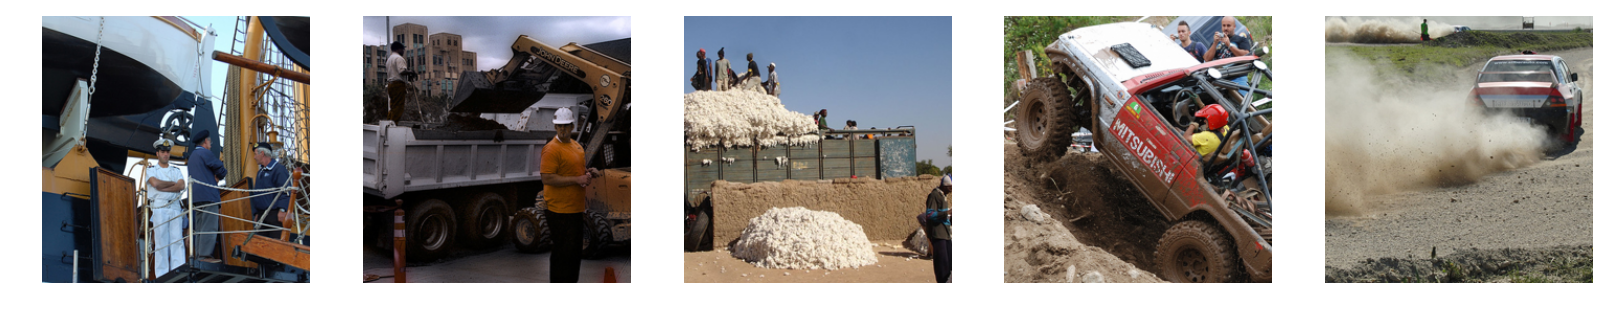

0: a group of men are loading cotton onto a truck


In [42]:
fig = plt.figure(1, figsize = (20,10))

for ii in xrange(5):
    ax = fig.add_subplot(1, 5, ii+1)
    pred_image = LoadImage(image_path+image_list[top5[ii]])
    ax.imshow(pred_image)
    ax.axis('off')
                     
plt.show()
print("{}: {}".format(idx, sentence))


In [50]:
ranks = []
for x in xrange(len(preds)):
    idx = x # random image
    sentence = get_sentence(config['val'], idx)[0] # groundtruth sentence
    img = LoadImage(image_path+image_list[idx])
    top5 = calculate_top5(preds, config['fc7_val'], idx)
    ranks.append(np.where(top5 == idx)[0][0])

In [53]:
for y in ranks:
    print(y)

2
0
42
140
0
131
20
1
12
1
75
2
111
1
4
6
44
18
26
97
1
16
160
0
13
21
0
0
22
0
10
163
6
68
20
10
2
0
11
73
32
0
0
0
2
22
6
270
1
15
7
1
6
0
202
2
47
2
0
3
13
10
24
0
2
8
44
22
0
9
5
7
13
12
4
64
146
207
0
8
80
7
1
12
2
460
0
7
0
24
108
15
111
107
6
19
5
17
5
30
3
3
31
4
3
3
17
0
6
1
4
44
35
378
3
64
3
0
287
4
90
130
663
1
1
0
0
253
3
32
2
23
8
0
7
0
27
1
0
206
26
123
0
23
86
581
2
184
0
8
7
10
4
5
83
2
14
0
55
270
0
147
20
101
6
0
9
2
148
42
11
113
13
7
1
69
37
5
14
3
6
0
65
37
1
3
129
165
2
1
168
3
28
8
12
18
15
22
7
7
684
101
1
138
7
18
24
3
9
469
4
2
4
0
22
356
0
93
55
6
4
5
3
3
204
50
1
48
1
5
1
1
1
9
1
50
0
217
110
111
62
2
1
8
382
0
0
26
8
29
12
29
3
0
7
23
17
46
27
68
7
251
21
41
36
17
1
0
11
9
0
29
64
0
217
6
36
58
21
0
9
0
5
3
0
37
243
0
6
81
0
0
121
57
2
12
66
9
71
29
11
1
33
0
89
1
2
51
499
1
8
4
100
14
5
5
18
15
4
99
11
253
1
0
0
383
0
12
33
293
1
0
1
0
69
17
221
0
29
4
45
13
5
5
40
4
0
6
320
3
33
17
3
2
9
510
1
2
1
5
10
21
16
313
31
15
81
39
4
46
1
17
232
166
55
51
13
23
